# Problem 3



In [5]:
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import sample
import seaborn as sns
import scipy.stats as ss
from scipy import optimize
from statsmodels.api import OLS # has better summary stats than sklearn's OLSb
from random import sample
import  arviz as az

First load the data.

In [6]:
penguin = pd.read_csv("penguins.csv")
penguin.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


## Part 1

In [170]:
fl = penguin['flipper_length_mm']
penguin['flipper_length_norm'] = [(i-fl.mean())/fl.std() for i in fl.to_numpy()]
penguin['body_mass_kg'] = penguin['body_mass_g']/1000

print('Normalized flipper data:')
print('\tstd:',penguin['flipper_length_norm'].std())
print('\tmean:',round(penguin['flipper_length_norm'].mean(),10))

Normalized flipper data:
	std: 1.0000000000000002
	mean: -0.0


We can check to make sure the distributions look the same.

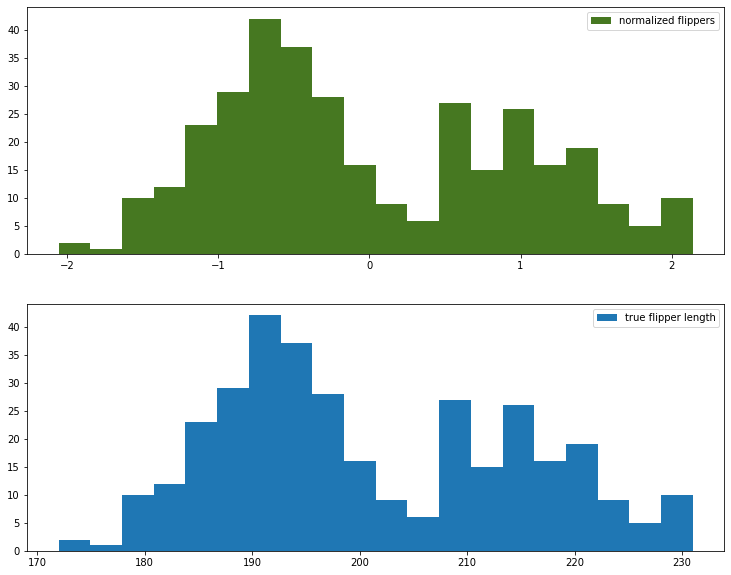

In [169]:
plt.figure(figsize=(12.5,10))
ax = plt.subplot(211)
plt.hist(penguin.flipper_length_norm.values, bins =20, label="normalized flippers",color="#467821")
plt.legend(loc="upper right");
ax = plt.subplot(212)
plt.hist(penguin.flipper_length_mm.values,bins =20,label="true flipper length")
plt.legend(loc="upper right");

What about the weight distribution of the penguins?

<Figure size 900x720 with 0 Axes>

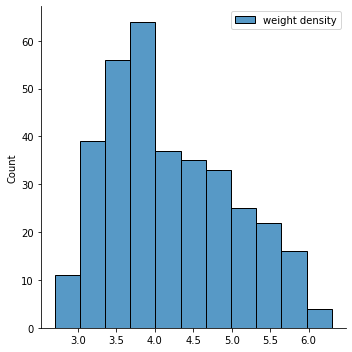

In [173]:
# curious about weight distribution
plt.figure(figsize=(12.5,10))
# plt.hist(penguin.body_mass_kg.values,label="non-normalized",bins = 50)
sns.displot(penguin.body_mass_kg.values, label="weight density")
plt.legend(loc="upper right")
plt.show();

## Part 2

We choose normal priors for $\alpha$ and $\beta$. The prior for $\beta$ has a mean of zero, so as not to impose an effect on the linear regression. For the variance, we choose a log-normal distribution.

In [147]:
def generate_parameters_prior():
    return [ss.norm(5,np.sqrt(0.6)).rvs(), # generates alph
            ss.norm(0,np.sqrt(0.2)).rvs(),  # generates beta
            ss.lognorm(s=1.25).rvs()]  # generates var #lognorm.rvs(s=5)

## Part 3

We can start by creating a funcvtion that samples X. 

In [148]:
def sample_from_x(num_samples):
    return sample(list(penguin['flipper_length_norm']),num_samples)

In [149]:
def generate_data(alpha, beta, var, X,num_samples=1):
    return ss.norm(alpha + beta * X, np.sqrt(var)).rvs(num_samples)

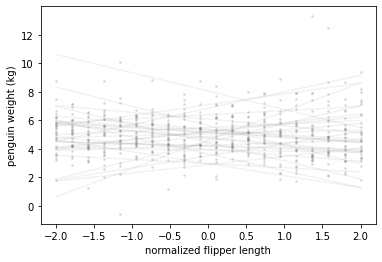

In [150]:
import random
random.seed(5)
for X in np.linspace(-2,2,30):

    params = generate_parameters_prior()

    num_samples = 50
    Y0 = generate_data(*params,-2)
    Y1 = generate_data(*params,2)
    
    x = np.linspace(-2,2,20)
    y = [generate_data(*params,i) for i in x]
    
    plt.plot([-2,2],[Y0,Y1], c='gray', alpha=0.1)
    plt.scatter(x,y,c='gray',s=3,alpha=0.2)

plt.xlabel('normalized flipper length')
plt.ylabel('penguin weight (kg)')
plt.savefig('prior_predictive.png')
plt.show()

## Part 4

In [151]:
def log_posterior(alpha, beta, var, Y, X):
    N = len(X)
    if var > 100 or var < 0:
        return -100000000000000000000
    return (-N * np.log(var) / 2 - np.sum((Y - alpha - beta * X) ** 2) / var +     # log_likelihood
        ss.norm(50, np.sqrt(200)).logpdf(alpha) +                           # log of the prior on alpha
        ss.norm(0, np.sqrt(100)).logpdf(beta))                              # log of the prior on beta

def minus_log_posterior(theta):
    Y = penguin['body_mass_kg']
    X = penguin['flipper_length_norm']
    return - log_posterior(*theta,Y,X)

In [152]:
fit = optimize.minimize(minus_log_posterior, [50, 0, 10])

In [153]:
# fit approx.
MAP = fit['x']
hess_inv  = fit['hess_inv']
approx = ss.multivariate_normal(MAP, hess_inv)

## Part 5

In [154]:
samples = approx.rvs(1000)

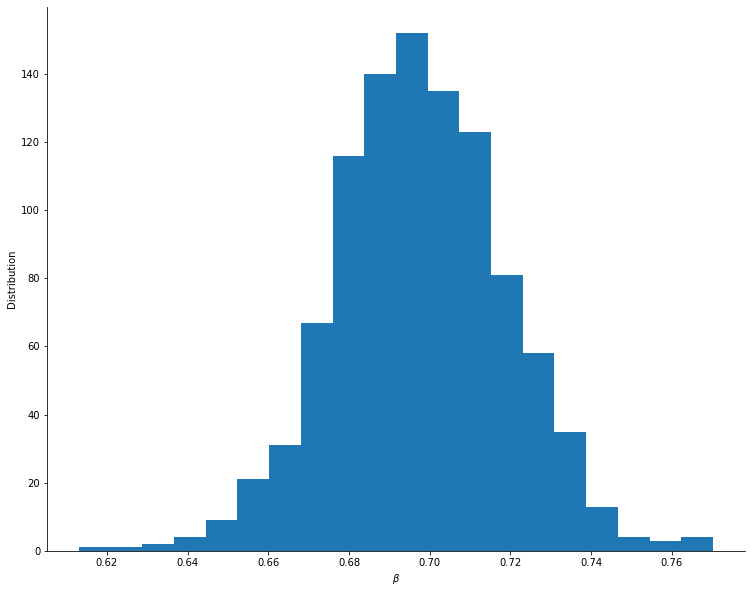

In [155]:
plt.figure(figsize=(12.5,10))
plt.hist(samples[:,1],bins = 20)
plt.ylabel('Distribution')
plt.xlabel(r'$\beta$')
sns.despine()

<Figure size 900x720 with 0 Axes>

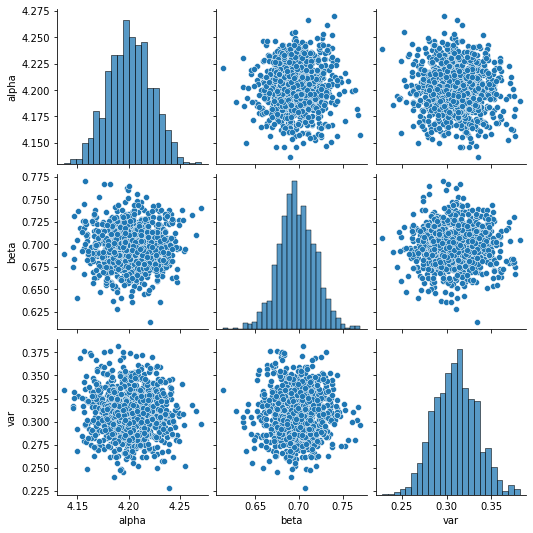

In [156]:
plt.figure(figsize=(12.5,10))
sns.pairplot(pd.DataFrame(samples, columns=['alpha', 'beta', 'var']))
plt.savefig('pairplot.png')

We can commute the highest density percentile for 95% inclusion for each of the parameters.

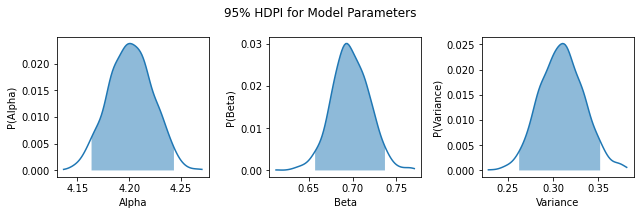

In [158]:
alphas, betas, variances = list(zip(*samples))

def calculate_kde(data):
    
    x = np.linspace(min(data),max(data),100)
    y= ss.gaussian_kde(data).pdf(x)
    
    y = y/sum(y) #normalize
    
    return x,y
    
def calculate_hdi(data):
    return az.hdi(np.array(data),0.95)

fig, ax = plt.subplots(1,3,figsize=(9,3))

x,y = calculate_kde(alphas)
ax[0].plot(x,y)
a,b = calculate_hdi(alphas)
ax[0].fill_between(x,y,where=(x>a)&(x<b),alpha=0.5)
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('P(Alpha)')

x,y = calculate_kde(betas)
ax[1].plot(x,y)
a,b = calculate_hdi(betas)
ax[1].fill_between(x,y,where=(x>a)&(x<b),alpha=0.5)
ax[1].set_xlabel('Beta')
ax[1].set_ylabel('P(Beta)')

x,y = calculate_kde(variances)
ax[2].plot(x,y)
a,b = calculate_hdi(variances)
ax[2].fill_between(x,y,where=(x>a)&(x<b),alpha=0.5)
ax[2].set_xlabel('Variance')
ax[2].set_ylabel('P(Variance)')

plt.suptitle('95% HDPI for Model Parameters')
plt.tight_layout()
plt.savefig('model_hdpi.png')
plt.show()

## Part 6

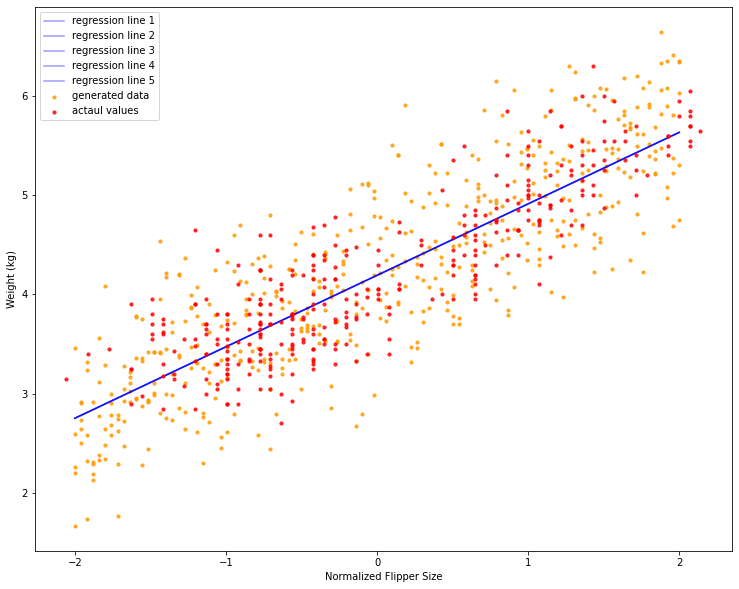

In [160]:
# data points and regression lines
x = np.linspace(-2, 2, 100)
plt.figure(figsize=(12.5,10))
appended_data = []
for i in range(1,6):  # 10 data sets

    params = approx.rvs()

    Y0 = generate_data(*params,x,100)  # simulate 100 measurements at 0
    plt.plot(x, alpha + beta*x, c='blue', alpha=0.4, zorder=-100,label='regression line %s' % i)

    temp_zipped = list(zip(x,Y0))
    df_temp = pd.DataFrame(temp_zipped, columns = ['x', 'y'])
    appended_data.append(df_temp)


appended_data = pd.concat(appended_data)
plt.scatter(appended_data['x'],appended_data['y'], c='#FF9A00',s = 10, alpha=.8,zorder=-100, label='generated data')
plt.xlabel('Normalized Flipper Size')
plt.ylabel('Weight (kg)')
plt.scatter(penguin['flipper_length_norm'], penguin['body_mass_kg'], s=10,alpha=.8, c='red',label="actaul values")
plt.legend()
plt.savefig('generate_sample_data.png')
plt.show()